# constructing a network for PPs based on their spatial location

In [3]:
import numpy as np
import sklearn
from nmf_with_missing_values import nmf_with_missing_values
import ipyvolume
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import scipy as sp
import networkx as nx
%matplotlib inline

## load the data

In [4]:
tmp = np.load('../data/mouse_brain_ISH_float32.npz')
data = tmp['data']
sections = tmp['sections']
original_shape = data.shape
d = data.shape[1] * data.shape[2] * data.shape[3]
data = np.reshape(data, (data.shape[0], d))

## load the PPs

In [5]:
f = np.load('../code/reza/nmf_result_ncomp_18.npz')
A = f['A']
original_shape = f['original_shape']
X_guess = f['X_guess']
D = f['D']

### compute the distances between different patterns
For two PPs, we compute their distance in the following way:
- First, select the top voxels from each PP based on intensities.
- Then, we compute the distance between two PPs using the distance between the two sets.

In [6]:
D_cube = A.reshape([18] + list(original_shape[1:])) # transform the vector to 3d tensor

In [7]:
assert np.allclose(D_cube[0,:], A[0, :].reshape(original_shape[1:]))

In [9]:
distance = np.zeros((18, 18))

# Step 1: select the top voxels for each PP
set_of_vectors = dict()
for i in range(18):
    threshold = np.quantile(D_cube[i,:,:,:].flatten(), .99)
    set_of_vectors[i] =  np.array([(x,y,z) for x in range(D_cube.shape[1]) for y in range(D_cube.shape[2]) for z in range(D_cube.shape[3]) if D_cube[i,x,y,z] > threshold])

In [12]:
# Step 2: compute the set distance
for i in range(18):
    for j in range(18):
        Y = sp.spatial.distance.cdist(set_of_vectors[i], set_of_vectors[j], metric='euclidean')
        distance[i][j] = np.min(Y.flatten())
        #print(i,j, distance[i][j])

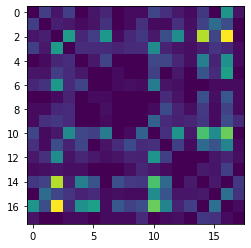

In [13]:
plt.imshow(distance)

### visualize the distance matrix

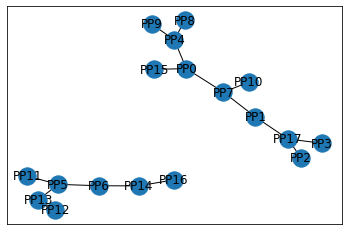

In [32]:
import networkx as nx
threshold = np.quantile(distance.flatten(), .1)
G=nx.Graph()
G.add_nodes_from(["PP{}".format(i) for i in range(18)])
for i in range(18):
    if np.any(distance[i][i+1:] < threshold):
        for j in range(i+1, 18):
            if distance[i][j] < threshold:
                G.add_edge("PP{}".format(i), "PP{}".format(j))
    else:
        tmp = distance[i]
        tmp[i] = 1e6
        ind = np.argmin(tmp)
        G.add_edge("PP{}".format(ind), "PP{}".format(i))
nx.draw_networkx(G)

In [1]:
G.degree()

NameError: name 'G' is not defined

### Observation: Compared with the correlation between PPs and the human labeled region, it seems that isolated PPs correspond better to the manual regions.

In [66]:
for i in range(18):
    print('PP{}'.format(i), G.degree('PP{}'.format(i)))

PP0 3
PP1 2
PP2 1
PP3 1
PP4 3
PP5 3
PP6 2
PP7 3
PP8 1
PP9 1
PP10 1
PP11 1
PP12 1
PP13 2
PP14 2
PP15 1
PP16 1
PP17 3


### Could be interesting to look at what are the two groups?

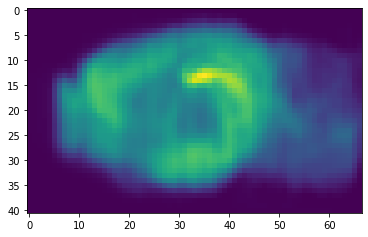

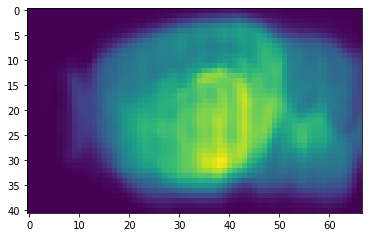

In [26]:
group1 = [16,14,6,1,5,13,12]
group2 = [0,1,2,3,4,5,7,8,9,10,11,15,17]

for i in group1:
    pass
    #plt.figure()
    #plt.imshow(np.sum(D_cube[i, :, :, :], 2))
plt.figure()
plt.imshow(np.sum(np.mean(D_cube[group1, :, :, :], 0), 2).T)
plt.figure()
plt.imshow(np.sum(np.mean(D_cube[group2, :, :, :], 0), 2).T)

In [35]:
set_of_vectors[5].shape

(1594, 3)